fraction of dynamic vs non-dynamic: 0.6914893617021277
confidence:  0.6914893617021277


/pollard/home/smorin/miniconda3/envs/r-environment/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


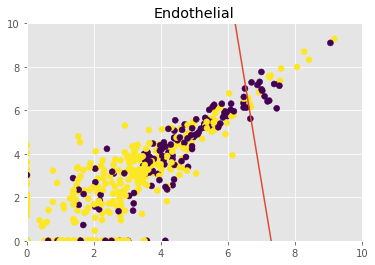

In [3]:
import numpy as np
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import svm
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
from sklearn.svm import LinearSVC  
style.use("ggplot")

#reads in all the sample names used as keys in the dictionary
def getFileNames(file, exp):
    samples_list = []
    inFile = open(file, 'r')
    for line in inFile:
        splitLine=line.strip().split('\n')
        name=splitLine[0]
        if exp in name:
            samples_list.append(name)
#         elif exp not in name:
#             print(name)
    inFile.close()
    return samples_list
    
#normalizes for sequencing depth CPM counts per million and for enhancer length KB (kilobase)
def normalize_CPKM(exp_dict):
    for name, counts in exp_dict.items():
        count_per_ehancer = [x[0] for x in counts]
        total_counts_per_sample = sum(count_per_ehancer)
        #update key with new values normalized by sequencing depth and by enhancer length
        cpkm_vals = [(tup[0] / (tup[1] * total_counts_per_sample)) * 10**9 for tup in counts]
        log_cpkm_vals = [np.log(x+1) for x in cpkm_vals]
        exp_dict[name] = log_cpkm_vals

def run_ds_on_exp(samples_dir, rel_path, exp):
#     print('exp: ', exp)
    sampleDict = {}
    samples = getFileNames(samples_dir, exp)
    for sample in samples:
        cts_counts_wlength(rel_path, sample, sampleDict)

    #rename dictionary keys to specify conditions and replicates         
    rename_keys(sampleDict)

    #normalize the data using CPKM
    normDict = norm(sampleDict, exp)
    
    return normDict

    
#TODO: use parserArg to take arguments for normalization, replicates, exp, etc
def combine_replicates(sampleDict, exp):
    replicateDict = {}
    sham_combined_endo = []
    for s1,s2 in zip(sampleDict['En_Sham_r1'],sampleDict['En_Sham_r2']):
        sham_combined_endo.append((s1[0]+s2[0], s1[1]))
    replicateDict[exp +'_Endo_Sham'] = sham_combined_endo
    
    sham_combined_fb = []
    for t1,t2 in zip(sampleDict['Fb_Sham_r1'],sampleDict['Fb_Sham_r2']):
        sham_combined_fb.append((t1[0]+t2[0], t1[1]))
    replicateDict[exp +'_Fb_Sham'] = sham_combined_fb
    
    sham_combined_mye = []
    for u1,u2 in zip(sampleDict['My_Sham_r1'],sampleDict['My_Sham_r2']):
        sham_combined_mye.append((u1[0]+u2[0], u1[1]))
    replicateDict[exp +'_Mye_Sham'] = sham_combined_mye
 
    TAC_combined_endo = []
    for x1,x2 in zip(sampleDict['En_TAC_r1'],sampleDict['En_TAC_r2']):
        TAC_combined_endo.append((x1[0]+x2[0], x1[1]))
    replicateDict[exp +'_Endo_TAC'] = TAC_combined_endo
    
    TAC_combined_fb = []
    for y1,y2 in zip(sampleDict['Fb_TAC_r1'],sampleDict['Fb_TAC_r2']):
        TAC_combined_fb.append((y1[0]+y2[0], y1[1]))
    replicateDict[exp +'_Fb_TAC'] = TAC_combined_fb
    
    TAC_combined_mye = []
    for z1,z2 in zip(sampleDict['My_TAC_r1'],sampleDict['My_TAC_r2']):
        TAC_combined_mye.append((z1[0]+z2[0], z1[1]))
    replicateDict[exp +'_Mye_TAC'] = TAC_combined_mye
    
    JQ1W_combined_endo = []
    for j1,j2 in zip(sampleDict['En_JQ1W_r1'],sampleDict['En_JQ1W_r2']):
        JQ1W_combined_endo.append((j1[0]+j2[0], j1[1]))
    replicateDict[exp +'_Endo_JQ1W'] = JQ1W_combined_endo
    
    JQ1W_combined_fb = []
    for k1,k2 in zip(sampleDict['Fb_JQ1W_r1'],sampleDict['Fb_JQ1W_r2']):
        JQ1W_combined_fb.append((k1[0]+k2[0], k1[1]))
    replicateDict[exp +'_Fb_JQ1W'] = JQ1W_combined_fb
    
    JQ1W_combined_mye = []
    for m1,m2 in zip(sampleDict['My_JQ1W_r1'],sampleDict['My_JQ1W_r2']):
        JQ1W_combined_mye.append((m1[0]+m2[0], m1[1]))
    replicateDict[exp +'_Mye_JQ1W'] = JQ1W_combined_mye
  
    JQ1_combined_endo = []
    for a1,a2 in zip(sampleDict['En_JQ1_r1'],sampleDict['En_JQ1_r2']):
        JQ1_combined_endo.append((a1[0]+a2[0], a1[1]))
    replicateDict[exp +'_Endo_JQ1'] = JQ1_combined_endo
    
    JQ1_combined_fb = []
    for b1,b2 in zip(sampleDict['Fb_JQ1_r1'],sampleDict['Fb_JQ1_r2']):
        JQ1_combined_fb.append((b1[0]+b2[0], b1[1]))
    replicateDict[exp +'_Fb_JQ1'] = JQ1_combined_fb
    
    JQ1_combined_mye = []
    for c1,c2 in zip(sampleDict['My_JQ1_r1'],sampleDict['My_JQ1_r2']):
        JQ1_combined_mye.append((c1[0]+c2[0], c1[1]))
    replicateDict[exp +'_Mye_JQ1'] = JQ1_combined_mye
    
#     print(replicateDict) 
    
    return replicateDict

def norm(sampleDict, exp):
    replCombinedDict = {}
#     print('replicates combined')
    replCombinedDict = combine_replicates(sampleDict, exp)
    normalize_CPKM(replCombinedDict)
    
    return replCombinedDict    

    
    
def rename_keys(sampleDict):
        #dictionary[new_key] = dictionary.pop(old_key)
        #https://stackoverflow.com/questions/4406501/change-the-name-of-a-key-in-dictionary
        #TODO: read in a list of ordered conditions with replicates and make this a for loop 
        sampleDict['En_Sham_r1'] = sampleDict.pop('Sample1_end')
        sampleDict['Fb_Sham_r1'] = sampleDict.pop('Sample1_fib')
        sampleDict['My_Sham_r1'] = sampleDict.pop('Sample1_mye')
        
        sampleDict['En_Sham_r2'] = sampleDict.pop('Sample2_end')
        sampleDict['Fb_Sham_r2'] = sampleDict.pop('Sample2_fib')
        sampleDict['My_Sham_r2'] = sampleDict.pop('Sample2_mye')
        
        sampleDict['En_TAC_r1'] = sampleDict.pop('Sample3_end')
        sampleDict['Fb_TAC_r1'] = sampleDict.pop('Sample3_fib')
        sampleDict['My_TAC_r1'] = sampleDict.pop('Sample3_mye')
        
        sampleDict['En_TAC_r2'] = sampleDict.pop('Sample4_end')
        sampleDict['Fb_TAC_r2'] = sampleDict.pop('Sample4_fib')
        sampleDict['My_TAC_r2'] = sampleDict.pop('Sample4_mye')
        
        sampleDict['En_JQ1W_r1'] = sampleDict.pop('Sample5_end')
        sampleDict['Fb_JQ1W_r1'] = sampleDict.pop('Sample5_fib')
        sampleDict['My_JQ1W_r1'] = sampleDict.pop('Sample5_mye')
        
        sampleDict['En_JQ1W_r2'] = sampleDict.pop('Sample6_end')
        sampleDict['Fb_JQ1W_r2'] = sampleDict.pop('Sample6_fib')
        sampleDict['My_JQ1W_r2'] = sampleDict.pop('Sample6_mye')
        
        sampleDict['En_JQ1_r1'] = sampleDict.pop('Sample7_end')
        sampleDict['Fb_JQ1_r1'] = sampleDict.pop('Sample7_fib')
        sampleDict['My_JQ1_r1'] = sampleDict.pop('Sample7_mye')
        
        sampleDict['En_JQ1_r2'] = sampleDict.pop('Sample8_end')
        sampleDict['Fb_JQ1_r2'] = sampleDict.pop('Sample8_fib')
        sampleDict['My_JQ1_r2'] = sampleDict.pop('Sample8_mye')
        

                
#stores cell type specific (cts) counts and length of enhancer as tuples into a dictionary using samples as key
def cts_counts_wlength(rel_path, file, exp_dict):
    counts_endo = []
    counts_fib = []
    counts_mye = []
    inFile = open(rel_path + file, 'r')
    for line in inFile:
        splitLine=line.strip().split('\t')
        start_pos = int(splitLine[1])
        end_pos = int(splitLine[2])
        length = (end_pos - start_pos)+1
        val_endo = int(splitLine[3])
        val_fib = int(splitLine[4])
        val_mye = int(splitLine[5])
        counts_endo.append((val_endo,length))
        counts_fib.append((val_fib,length))
        counts_mye.append((val_mye,length))
    inFile.close()
    sample = file[:7]
#     print(len(counts_endo), len(counts_fib), len(counts_mye))
    exp_dict[sample + '_end'] = counts_endo
    exp_dict[sample + '_fib'] = counts_fib
    exp_dict[sample + '_mye'] = counts_mye

def merge(expDict, cellType, exp):
    count = 0
    mergeList = []
    for w,x,y,z in zip(expDict[exp+'_'+cellType+'_Sham'], 
                       expDict[exp+'_'+cellType+'_TAC'], 
                       expDict[exp+'_'+cellType+'_JQ1W'], 
                       expDict[exp+'_'+cellType+'_JQ1']):
        #for this model we want to use the conditions in the order they were administered (eg. JQ1 then JQ1W)
#         print(w,x)
        mergeList.append([w,x,z,y])
#         mergeList.append([w,x])
#         if w== 0.0 and x ==0.0 and y ==0.0 and z == 0.0:
#             count+=1
#     print(exp, cellType, count)
    return mergeList    

def create_binary_array(cellType_atac):
    binary_array = []
    for condition in cellType_atac:
        #order: sham, TAC, JQ1, JQ1W
        unstressed = condition[0] + condition[2]
        stressed = condition[1] + condition[3]
        if stressed > unstressed:
            binary_array.append(1) #dynamic enhancer
        else:
            binary_array.append(0) #non-dynamic enhancer
    return binary_array 
    
#----------------MAIN PROGRAM
rel_path = "../../../data/projects/morin/Counts/cellType_specific_counts/"
#store data in dictionary using key:sample, value: log(count+1) for CPM normalization
#and value: (log(count+1), length) for CPKM normalization


#retrieve samples from specified experiment
#experimental data
cpm_bool = False #False: normalize by cpkm, True: normalize by cpm
repl_bool = True #True:use sum of replicates, False: use r1, r2

#file holding 16 sample names
#8 samples per experiment 
#a file containing the samples with their respective counts
# cellType_scpecific_counts.txt chr1|start_pos|end_pos|endo_count|fib_count|myo_count
samples_dir = "../../../data/projects/morin/cellType_specific_counts.txt"


rnaDict= run_ds_on_exp(samples_dir, rel_path, "RNA")
# print(rnaDict)

#normalize atac data
atacDict= run_ds_on_exp(samples_dir, rel_path, "ATAC")


#merge conditions within celltypes for RNA
endo_rna = merge(rnaDict, 'Endo', 'RNA')
fib_rna = merge(rnaDict, 'Fb', 'RNA')
mye_rna = merge(rnaDict, 'Mye', 'RNA')


# print(endo_rna)
# plt.scatter(x,y)
# plt.show()

#the feature list being stored in a capital X variable
# sham ,tac, jq1, jq1w], #unstressed , stressed, unstressed, stressed
# X = np.array([[1,5],
#              [5,8],
#              [1.5,1.8],
#              [8,8],
#              [1,0.6],
#              [9,11]])

 
X= np.array(endo_rna)

#For our labels, sometimes referred to as "targets," we're going to use 0 or 1
#from ATAC data
#generate an array of dynamic vs non dynamic
#get the fractions of 1s and 0s - our preditiction has to be greater than this fraction (means we are better than random)
# y = [0,1,0,1,0,1]

#merge conditions within celltypes for ATAC
endo_atac = merge(atacDict, 'Endo', 'ATAC')
fib_atac = merge(atacDict, 'Fb', 'ATAC')
mye_atac = merge(atacDict, 'Mye', 'ATAC')

binary_array = create_binary_array(endo_atac)

y = binary_array


# plt.scatter(x,y)
# plt.show()

count=0
for x in binary_array:
    if x == 1:
        count+=1
print("fraction of dynamic vs non-dynamic:", count/len(binary_array))
        

#define our classifier
# C is a valuation of "how badly" you want to properly classify, or fit, everything (using default for now)
# clf = svm.SVC(kernel='linear', C = 1.0)

linear_svm = LinearSVC()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

linear_svm.fit(X_train, y_train)

line = np.linspace(0, 10)  
for coef, intercept in zip(linear_svm.coef_, linear_svm.intercept_):  
    plt.plot(line, -(line * coef[0] + intercept) / coef[1])

#visualize the data
# w = clf.coef_[0]
# print(w)

# a = -w[0] / w[1]

# xx = np.linspace(0,10)
# yy = a * xx - clf.intercept_[0] / w[1]



#test accuracy
confidence = linear_svm.score(X_test, y_test)
print('confidence: ', confidence)

# h0 = plt.plot(xx, yy, 'k-', label="non weighted div")

#passes list of all elements in column 0, list of all elements in column 1
unstressed = []
for a,b in zip(X[:, 0], X[:, 2]):
    unstressed.append(a+b)

stressed = []
for c,d in zip(X[:, 1], X[:, 3]):
    stressed.append(c+d)
    
plt.ylim(0,10)
plt.xlim(0,10)


# plt.scatter(np.array(unstressed), np.array(stressed), c =y)
plt.scatter(X[:, 0], X[:, 1], c =y)
plt.title('Endothelial')
# plt.legend()
plt.show()